In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Import all curve reparametrization functions
from deepshape.curves import *

# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# Analytic diffeomorphism
g = LogStepDiff()

# Define Curves 
c1 = Infinity()  # See deepshape.curves.curves for definition.
c2 = c1.compose(g)

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
# q, r = Qmap(c2), Qmap(c1)
q, r = SRVT(c2), SRVT(c1)

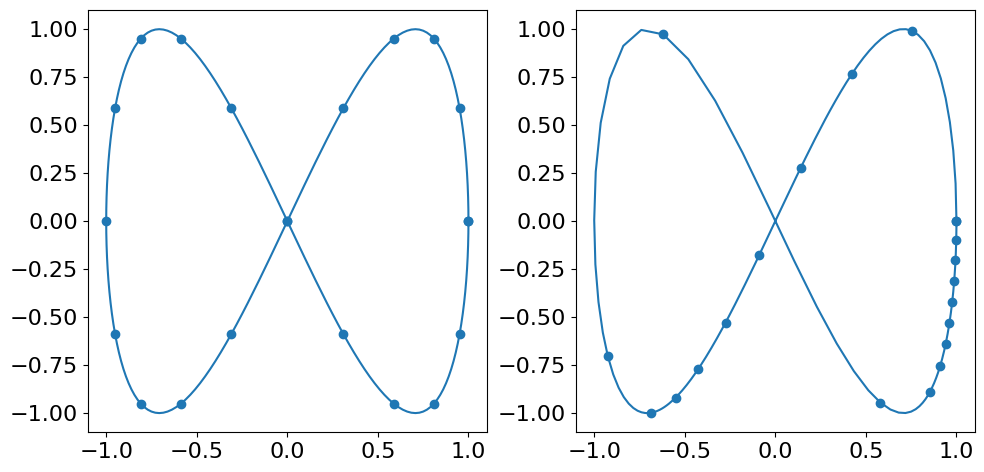

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_curve(c1, dotpoints=21, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.tight_layout()
plt.show()

In [5]:
# Create reparametrization network
RN = ReparametrizationNetwork(nn.ModuleList([
    PalaisLayer(10) for _ in range(10)
]))

# Define loss function
loss_func = ShapeDistance(q, r, k=256)

# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=0.1, max_iter=200, line_search_fn='strong_wolfe')
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# Train with BFGS-optimizer
error = reparametrize(q, r, RN, loss_func, optimizer, 100, Logger(5))#, scheduler=scheduler)

Iterations 250
[Iter     6] loss: 2.465485
[Iter    11] loss: 0.857865
[Iter    16] loss: 0.492981
[Iter    21] loss: 0.161836
[Iter    26] loss: 0.041666
[Iter    31] loss: 0.006438
[Iter    36] loss: 0.004044
[Iter    41] loss: 0.001841
[Iter    46] loss: 0.001246
[Iter    51] loss: 0.000938
[Iter    56] loss: 0.000636
[Iter    61] loss: 0.000571
[Iter    66] loss: 0.000544
[Iter    71] loss: 0.000505
[Iter    76] loss: 0.000461
[Iter    81] loss: 0.000424
[Iter    86] loss: 0.000379
[Iter    91] loss: 0.000355
[Iter    96] loss: 0.000311
[Iter   101] loss: 0.000293
[Iter   106] loss: 0.000290
[Iter   111] loss: 0.000274
[Iter   116] loss: 0.000259
[Iter   121] loss: 0.000244
[Iter   126] loss: 0.000238
[Iter   131] loss: 0.000233
[Iter   136] loss: 0.000227
[Iter   141] loss: 0.000203
[Iter   146] loss: 0.000184
[Iter   151] loss: 0.000178
[Iter   156] loss: 0.000177
[Iter   161] loss: 0.000177
[Iter   166] loss: 0.000175
[Iter   171] loss: 0.000175
[Iter   176] loss: 0.000174
[Iter

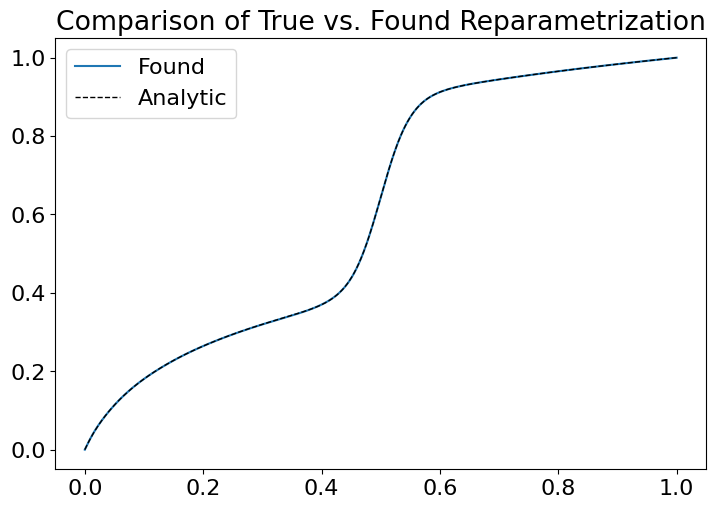

In [6]:
x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

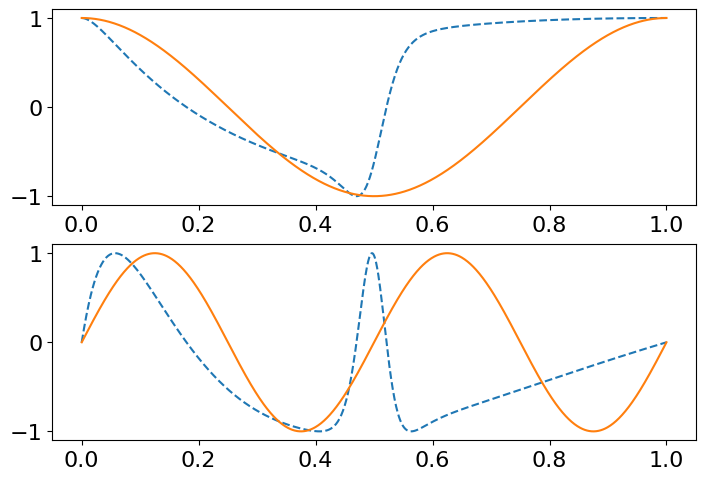

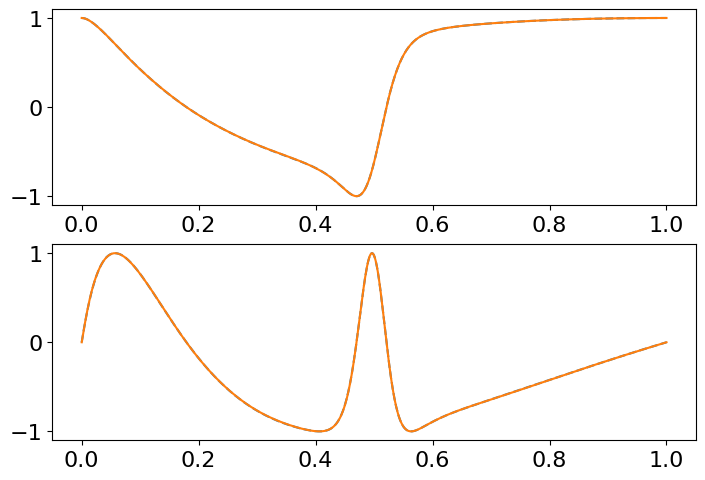

In [7]:
# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

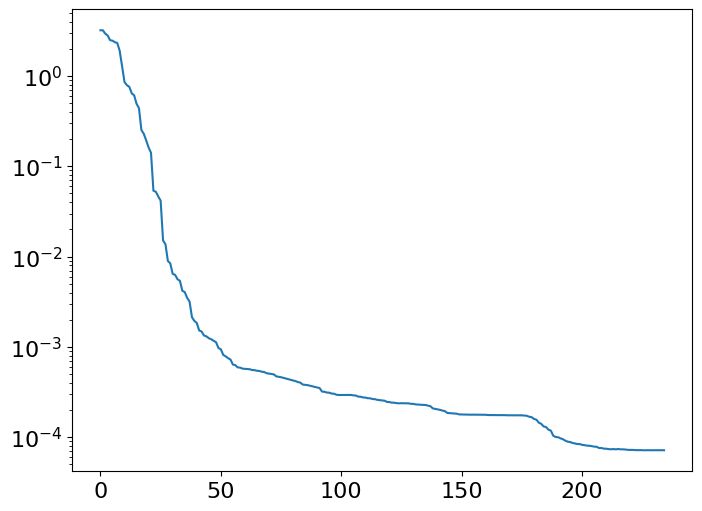

In [8]:
plt.figure()
plt.semilogy(error)
plt.show()